<a href="https://colab.research.google.com/github/HelloShagun/useful_libs/blob/main/examples/end_to_end_Lakes_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from watermask_tools.io_stack import read_stack, get_band_mask

arr, meta = read_stack("/content/sample_data/Water_Mask_Comparison_Figure (1).tif")
print(arr.shape)
print(meta)




(10, 1178, 1467)
StackMeta(tif_path='/content/sample_data/Water_Mask_Comparison_Figure (1).tif', band_desc=['SARL_Water', 'ESA_Water', 'JRC_Water', 'DW_Water', 'HydroLAKES', 'AE_ge_60', 'AE_ge_65', 'AE_ge_70', 'AE_ge_75', 'AE_ge_80'], transform=Affine(8.983152841195215e-05, 0.0, 77.6501036647062,
       0.0, -8.983152841195215e-05, 13.03015302768209), crs=CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), nodata=None, pixel_size_m=None, pixel_area_m2=8.069703496827366e-09)


In [23]:
from watermask_tools.io_stack import read_stack, get_band_mask
from watermask_tools.morphology import MorphologyConfig, clean_mask

tif = "/content/sample_data/Water_Mask_Comparison_Figure (1).tif"
arr, meta = read_stack(tif)

# pick a band that exists in your stack
mask = get_band_mask(arr, meta.band_desc, "AE_ge_70")

cfg = MorphologyConfig(
    pixel_size_m=10.0,
    merge_dist_m=50.0,
    min_area_m2=300.0,
    fill_holes=True,
    connectivity=4
)

final_mask, steps = clean_mask(mask, cfg, pixel_area_m2=100.0, return_intermediate=True)

print("Raw pixels:", int(steps["raw"].sum()))
print("After closing:", int(steps["after_closing"].sum()))
print("After fill holes:", int(steps["after_fill_holes"].sum()))
print("Final pixels:", int(final_mask.sum()))
print("Step keys:", list(steps.keys()))


Raw pixels: 25615
After closing: 32783
After fill holes: 32783
Final pixels: 32751
Step keys: ['raw', 'after_closing', 'after_fill_holes', 'final']


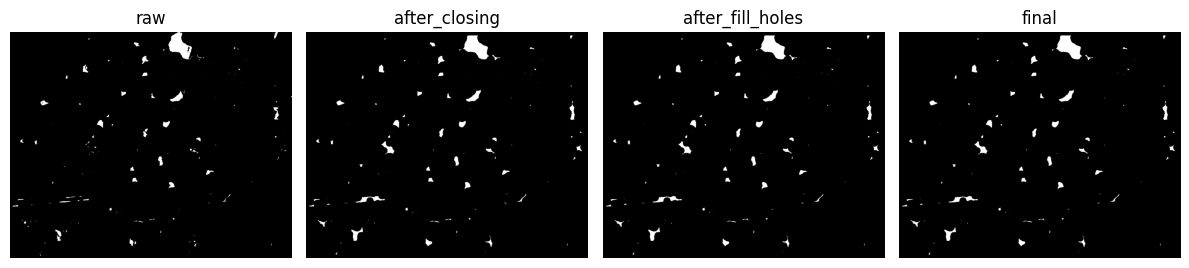

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,3))
for i, k in enumerate(["raw","after_closing","after_fill_holes","final"], start=1):
    plt.subplot(1,4,i)
    plt.imshow(steps[k], cmap="gray")
    plt.title(k)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [1]:
from watermask_tools.io_stack import read_stack, get_band_mask
from watermask_tools.objects import ObjectConfig, label_and_stats, object_areas_ha, ecdf_xy

tif = "/content/sample_data/Water_Mask_Comparison_Figure (1).tif"
arr, meta = read_stack(tif)

mask = get_band_mask(arr, meta.band_desc, "AE_ge_70")

cfg_obj = ObjectConfig(connectivity=4, pixel_area_m2=100.0)
df, inter = label_and_stats(mask, cfg_obj, return_intermediate=True)

print(df.head())
print("n objects:", inter["n"])

areas = object_areas_ha(mask, pixel_area_m2=100.0, connectivity=4)
xs, ys = ecdf_xy(areas)
print("ECDF points:", None if xs is None else len(xs))


   obj_id  px_count   area_m2  area_ha
0       1      9176  917600.0    91.76
1       2       362   36200.0     3.62
2       3         1     100.0     0.01
3       4         1     100.0     0.01
4       5        35    3500.0     0.35
n objects: 202
ECDF points: 202


,source,merge_dist_m,n_objects_raw,n_objects_consolidated,median_ha_raw,median_ha_consolidated
0,SARL_Water,30.0,106,89,0.180,0.300
1,ESA_Water,30.0,139,66,0.030,0.290
2,JRC_Water,30.0,130,106,0.270,0.480
3,DW_Water,30.0,108,64,0.130,0.560
4,HydroLAKES,30.0,4,4,95.845,95.395
5,AE_ge_70,30.0,202,136,0.090,0.260


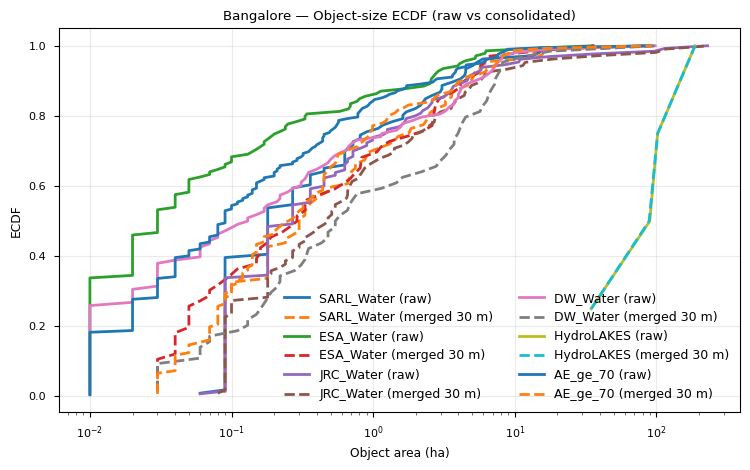

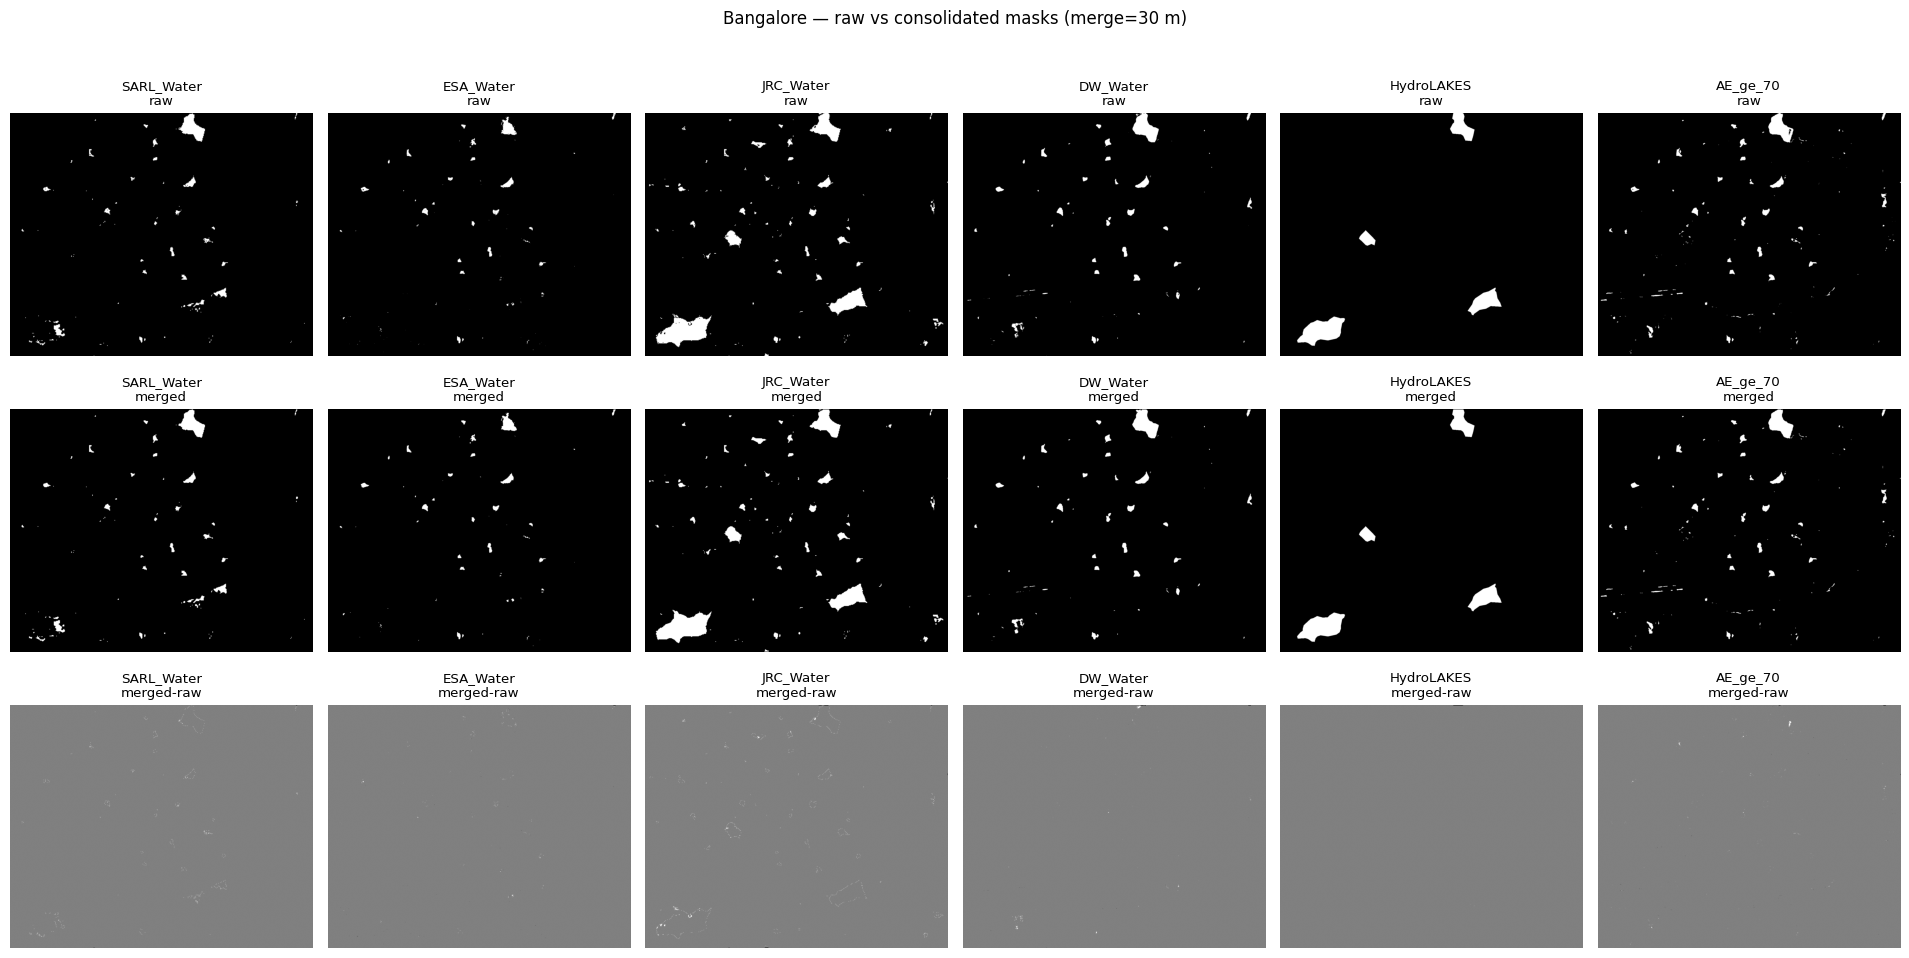

In [1]:

from watermask_tools.morphology import MorphologyConfig
from watermask_tools.objects import ObjectConfig
from watermask_tools.fragmentation_ecdf import plot_ecdf_raw_vs_consolidated

SOURCES = ["SARL_Water", "ESA_Water", "JRC_Water", "DW_Water", "HydroLAKES", "AE_ge_70"]

morph_cfg = MorphologyConfig(
    pixel_size_m=10.0,
    merge_dist_m=30.0,
    min_area_m2=300.0,
    fill_holes=True,
    connectivity=4
)

obj_cfg = ObjectConfig(connectivity=4, pixel_area_m2=100.0)

fig, ax, summary = plot_ecdf_raw_vs_consolidated(
    tif_path="/content/sample_data/Water_Mask_Comparison_Figure (1).tif",
    sources=SOURCES,
    morph_cfg=morph_cfg,
    obj_cfg=obj_cfg,
    site="Bangalore",
    show_masks=True,          # ✅ shows images
    max_sources_to_show=6,
    show_diff=True,
    return_fig=True,
    return_tables=True
)

summary


In [1]:
from watermask_tools.io_stack import read_stack, get_band_mask
from watermask_tools.morphology import MorphologyConfig, clean_mask

# 1) Read stack
tif = "/content/sample_data/Water_Mask_Comparison_Figure (1).tif"
arr, meta = read_stack(tif)

# 2) Decide which bands you want
BASE_PRODUCTS = ["SARL_Water","ESA_Water","JRC_Water","DW_Water","HydroLAKES"]
AE_MAIN = "AE_ge_70"

# 3) Morphology config (same as used elsewhere)
morph_cfg = MorphologyConfig(
    pixel_size_m=10.0,
    merge_dist_m=30.0,
    min_area_m2=300.0,
    fill_holes=True,
    connectivity=4
)

# 4) Build masks dict
masks = {}
for name in BASE_PRODUCTS + [AE_MAIN]:
    raw = get_band_mask(arr, meta.band_desc, name)
    masks[name] = clean_mask(
        raw,
        morph_cfg,
        pixel_area_m2=100.0,
        return_intermediate=False
    )

print("Masks built:", list(masks.keys()))


Masks built: ['SARL_Water', 'ESA_Water', 'JRC_Water', 'DW_Water', 'HydroLAKES', 'AE_ge_70']


In [2]:
from watermask_tools.matching import union_masks

any_prod = union_masks(
    masks,
    ["SARL_Water","ESA_Water","JRC_Water","DW_Water","HydroLAKES"]
)


In [5]:
from watermask_tools.objects import ObjectConfig, label_and_stats
from watermask_tools.matching import MatchConfig, compare_object_set_to_mask

# 1) Label AE
obj_cfg = ObjectConfig(connectivity=4, pixel_area_m2=100.0)
ae_stats, ae_inter = label_and_stats(
    masks[AE_MAIN],
    obj_cfg,
    return_intermediate=True
)
ae_lab = ae_inter["labels"]

# 2) Match
cfg_match = MatchConfig(
    pixel_size_m=10.0,
    dist_tol_m=30.0,
    overlap_frac_tol=0.10
)


per_obj, summary = compare_object_set_to_mask(
    source_labels=ae_lab,
    reference_mask=masks["DW_Water"],
    source_stats=ae_stats,
    cfg=cfg_match
)
summary


{'n_objects_source': 136,
 'n_objects_supported': 56,
 'n_objects_unsupported': 80,
 'fraction_unsupported': 0.5882352941176471,
 'unsupported_area_ha_total': 19.02,
 'unsupported_area_ha_median': 0.11499999999999999}

In [17]:
import importlib
import watermask_tools.vectorize as vec
importlib.reload(vec)

# test (use your existing ae_lab / ae_stats / meta)
ae_gdf = vec.labels_to_geodataframe(
    label_image=ae_lab,
    obj_stats=ae_stats,
    transform=meta.transform,
    crs=meta.crs,
)

print(type(ae_gdf), ae_gdf.crs, ae_gdf.geom_type.unique())
ae_gdf.head()


<class 'geopandas.geodataframe.GeoDataFrame'> EPSG:4326 ['Polygon']


,obj_id,geometry,px_count,area_m2,area_ha
0,2,"POLYGON ((77.77425 13.02997, 77.77425 13.02979...",341,34100.0,3.41
1,3,"POLYGON ((77.68667 13.0271, 77.68667 13.02683,...",35,3500.0,0.35
2,4,"POLYGON ((77.70831 13.0253, 77.70831 13.02521,...",373,37300.0,3.73
3,5,"POLYGON ((77.75503 13.02306, 77.75503 13.02297...",49,4900.0,0.49
4,6,"POLYGON ((77.75637 13.02252, 77.75637 13.02243...",17,1700.0,0.17


In [22]:
from watermask_tools.wayback_export import export_wayback_panels, ExportStyle

tmp_geojson = "/content/ae_new_lakes.geojson"   ###### Here we save the file first and then give the path later.
ae_gdf.to_file(tmp_geojson, driver="GeoJSON")

style = ExportStyle(
    pad_m=250,
    dpi=450,
    draw_coords=True,
    draw_scalebar=True,
    draw_north_arrow=True
)

saved = export_wayback_panels(
    polygons_path=tmp_geojson,
    out_dir="/content/wayback_pngs",
    wayback_date="2021-01-13",
    mode="grouped",          # or "individual"
    group_eps_m=400,         # only matters if grouped
    id_field="obj_id",       # optional (if your geojson has this field)
    style=style,
)

saved[:1], len(saved)


In [29]:
export_wayback_panels?

## Pushing it in Github

In [ ]:
## Pushing the directory to github

In [30]:
!git config --global user.email "shagun.garg.c2020@iitbombay.org"
!git config --global user.name "HelloShagun"


In [34]:
!git clone https://github.com/HelloShagun/useful_libs

Cloning into 'useful_libs'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 19 (delta 2), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), 1.08 MiB | 4.15 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [39]:
cd useful_libs

[Errno 2] No such file or directory: 'useful_libs'
/content/watermask_tools/useful_libs


In [36]:
mkdir lake_maps_comparison

In [40]:
cp /content/watermask_tools/fragmentation_ecdf.py

cp: missing destination file operand after '/content/watermask_tools/fragmentation_ecdf.py'
Try 'cp --help' for more information.


In [43]:
!git commit -m "Lake Comparison end to end"

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


In [44]:
!git push https://TOCKEN@github.com/HelloShagun/useful_libs


Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 2 threads
Compressing objects: 100% (9/9), done.
Writing objects: 100% (10/10), 10.04 KiB | 10.04 MiB/s, done.
Total 10 (delta 0), reused 1 (delta 0), pack-reused 0
To https://github.com/HelloShagun/useful_libs
   99a84fb..5884dbc  main -> main
